# Movie Recommendation System

## Environment settings

In [1]:
import os
import sys

# Add the path to the root directory of the project to the system path
ROOT_PATH = "D:\\Internship"
sys.path.append(os.path.join(ROOT_PATH, "recsys\\movie_recommendation_system\\src"))

# Dependencies
import pandas as pd
import torch

# My scripts
from movie_recommender.data.tabular_dataset_handler import TabularDatasetHandler
from movie_recommender.data.graph_dataset_handler import HeterogeneousGraphDatasetHandler
from movie_recommender.models.gnn_model import GCNEncoder, GraphSAGEEncoder, GATEncoder
from movie_recommender.models.gnn_train_eval_pred import GNNModelHandler
from movie_recommender.recommenders.collaborative_filtering import CollaborativeFiltering
from movie_recommender.recommenders.hybrid_filtering import HybridFiltering

# Remove warnings
import warnings; warnings.simplefilter('ignore')

# Data and trained models paths
data_path = os.path.join(ROOT_PATH, "resources", "movielens")
processed_data_path = os.path.join(ROOT_PATH, "resources", "movielens_processed")
trained_models_path = os.path.join(ROOT_PATH, "trained_models")

tdh_filepath = os.path.join(processed_data_path, "tdh_instance.pkl")
gdh_filepath = os.path.join(processed_data_path, "gdh_instance.pkl")

In [2]:
# Check if CUDA is available:
if torch.cuda.is_available():
    print("CUDA is available.")
    
    # Get the number of available GPUs:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # Get information about each GPU:
    for i in range(torch.cuda.device_count()):
        gpu = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu.name}, Compute Capability: {gpu.major}.{gpu.minor}")
    
    # Get the currently selected GPU:
    current_gpu = torch.cuda.current_device()
    print(f"Currently selected GPU number: {current_gpu}")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs available: 1
GPU 0: NVIDIA GeForce GTX 970, Compute Capability: 5.2
Currently selected GPU number: 0


# Tabular dataset preparation

## Data loading

In [3]:
# Define a tabular dataset handler
tdh = TabularDatasetHandler(data_path)

# Load movies_df
tdh.load_datasets()
tdh.get_movies_df_deepcopy().shape

(45466, 24)

In [4]:
tdh.get_movies_df_deepcopy().head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
tdh.get_movies_df_deepcopy().dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

## Data preprocessing

In [6]:
# Tabular dataset preprocessing
tdh.preprocess_datasets()
tdh.get_movies_df_deepcopy().shape

(45433, 22)

In [7]:
tdh.get_movies_df_deepcopy().head()

,adult,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0,1995
1,False,None,65000000,"[Adventure, Fantasy, Family]",NaN,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995
3,False,None,16000000,"[Comedy, Drama, Romance]",NaN,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995


In [8]:
tdh.get_movies_df_deepcopy().dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                         int32
original_language         object
original_title            object
overview                  object
popularity                object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
vote_average             float64
vote_count               float64
year                      object
dtype: object

In [9]:
# Store the TabularDatasetHandler instance locally
tdh.store_class_instance(filepath=tdh_filepath)

Class instance saved to 'D:\Internship\resources\movielens_processed\tdh_instance.pkl'


# Collaborative filtering: GNN-based

## Create a new user to suggest movies to

In [10]:
from movie_recommender.recommenders.popularity_ranking import PopularityRanking

users_ratings_df = tdh.get_users_ratings_df_deepcopy()
movies_df = tdh.get_movies_df_deepcopy()

# Create a new user
new_user_id = users_ratings_df['userId'].max() + 1

# Popularity Ranking in this case is one good possible solution to solve the cold-start problem
print('Most rated movies:')
most_rated_movies = PopularityRanking.top_movies_IMDB_wr_formula(tdh, 15)
most_rated_movies = most_rated_movies[['id', 'title']].set_index('id')
print(most_rated_movies)

# Initialize the movies ratings list
ratings = []

Most rated movies:
                                                    title
id                                                       
19404                         Dilwale Dulhania Le Jayenge
27205                                           Inception
155                                       The Dark Knight
157336                                       Interstellar
550                                            Fight Club
120     The Lord of the Rings: The Fellowship of the Ring
680                                          Pulp Fiction
278                              The Shawshank Redemption
122         The Lord of the Rings: The Return of the King
13                                           Forrest Gump
121                 The Lord of the Rings: The Two Towers
11                                              Star Wars
105                                    Back to the Future
238                                         The Godfather
1891                              The Empire Strikes 

In [11]:
# Set the new_user's ratings for the 'most_rated_movies', to avoid the cold-start problem
ratings.append({'movieId': 19404, 'rating': 1.5, 'userId': new_user_id})
ratings.append({'movieId': 27205, 'rating': 2, 'userId': new_user_id})
ratings.append({'movieId': 155, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 157336, 'rating': 3, 'userId': new_user_id})
ratings.append({'movieId': 550, 'rating': 3, 'userId': new_user_id})
ratings.append({'movieId': 120, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 680, 'rating': 2, 'userId': new_user_id})
ratings.append({'movieId': 278, 'rating': 1.5, 'userId': new_user_id})
ratings.append({'movieId': 122, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 13, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 121, 'rating': 5, 'userId': new_user_id})
ratings.append({'movieId': 11, 'rating': 2.5, 'userId': new_user_id})
ratings.append({'movieId': 105, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 238, 'rating': 3.5, 'userId': new_user_id})
ratings.append({'movieId': 1891, 'rating': 2.5, 'userId': new_user_id})
ratings

[{'movieId': 19404, 'rating': 1.5, 'userId': 672},
 {'movieId': 27205, 'rating': 2, 'userId': 672},
 {'movieId': 155, 'rating': 3.5, 'userId': 672},
 {'movieId': 157336, 'rating': 3, 'userId': 672},
 {'movieId': 550, 'rating': 3, 'userId': 672},
 {'movieId': 120, 'rating': 5, 'userId': 672},
 {'movieId': 680, 'rating': 2, 'userId': 672},
 {'movieId': 278, 'rating': 1.5, 'userId': 672},
 {'movieId': 122, 'rating': 5, 'userId': 672},
 {'movieId': 13, 'rating': 5, 'userId': 672},
 {'movieId': 121, 'rating': 5, 'userId': 672},
 {'movieId': 11, 'rating': 2.5, 'userId': 672},
 {'movieId': 105, 'rating': 3.5, 'userId': 672},
 {'movieId': 238, 'rating': 3.5, 'userId': 672},
 {'movieId': 1891, 'rating': 2.5, 'userId': 672}]

## Graph dataset construction

In [12]:
# Define a graph dataset handler
gdh = HeterogeneousGraphDatasetHandler(preprocessed_tdh=tdh)

In [13]:
# Add the new user and its ratings to the graph dataset (before building the graph)
gdh._users_ratings_df = pd.concat([gdh._users_ratings_df, pd.DataFrame(ratings)], ignore_index=True)

In [14]:
# Build the graph dataset
gdh.build_graph_dataset()

In [15]:
dataset = gdh.get_graph_dataset()
dataset

HeteroData(
  user={
    node_id=[672],
    x=[672, 600],
  },
  movie={
    node_id=[45433],
    x=[45433, 405],
  },
  (user, rating, movie)={
    edge_index=[2, 45004],
    edge_label=[45004],
    y=[45004],
  },
  (movie, rev_rating, user)={
    edge_index=[2, 45004],
    edge_label=[45004],
    y=[45004],
  }
)

In [16]:
# Print dataset information
print("Dataset size: ", dataset.size())
print("\nDataset type: ", type(dataset))
print("\nDataset metadata: ", dataset.metadata())
print("\nDataset to dict: ", dataset.to_dict())

Dataset size:  (46105, 46105)

Dataset type:  <class 'torch_geometric.data.hetero_data.HeteroData'>

Dataset metadata:  (['user', 'movie'], [('user', 'rating', 'movie'), ('movie', 'rev_rating', 'user')])

Dataset to dict:  {'_global_store': {}, 'user': {'node_id': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 

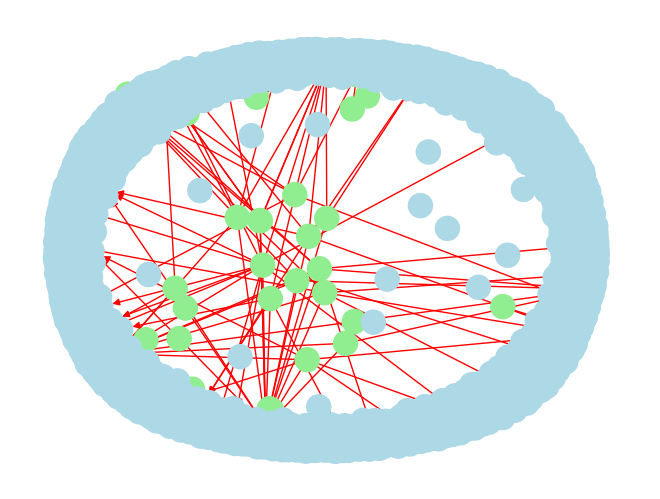

In [17]:
# Visualize a sampled (sub)graph dataset (for better visualization reasons)
gdh.plot_graph_dataset(node_sample_ratio=0.05, with_labels=False)

In [18]:
# Store the HeterogeneousGraphDatasetHandler instance locally
gdh.store_class_instance(filepath=gdh_filepath)

Class instance saved to D:\Internship\resources\movielens_processed\gdh_instance.pkl


In [19]:
# Save the dataset locally on disk
#gdh.save_graph_dataset()

In [20]:
# Load the dataset from disk
#dataset = gdh.load_graph_dataset()
#dataset

## GNN models training and evaluation

### GCN

In [21]:
GCN_model = GNNModelHandler(
    graph_dataset_handler=gdh,
    gnn_encoder=GCNEncoder(hidden_channels=64, out_channels=64)
)

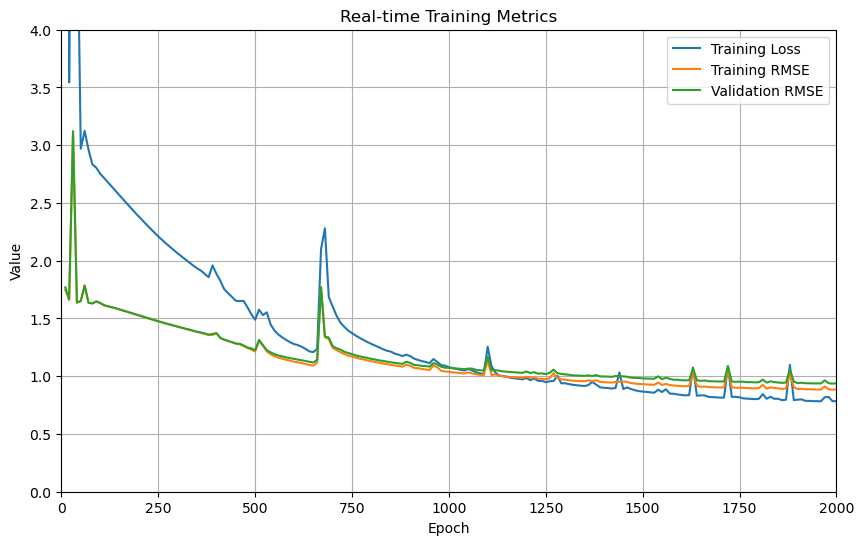

Best model with lowest validation RMSE restored from epoch 1997.

TensorBoard training information of model GCN_based_model saved at path: D:\Internship\trained_models\runs\training_plot_GCN_based_model_2000_epochs_0.001_lr

Trained model GCN_based_model saved at path: D:\Internship\trained_models


In [22]:
GCN_model.train(num_epochs=2000, lr=0.001, trained_model_path=trained_models_path, plot_train_loop=True)

In [23]:
GCN_model.evaluate_performance()

Device: 'cuda
'
Test RMSE: 1.0150, Test MAE: 0.7699

      userId  movieId  pred_rating  gt_rating
0        486     6770     4.376434        3.0
1        387     7877     3.302312        3.0
2        533    33193     5.000000        4.0
3        267    13312     3.372128        3.5
4        653    22120     4.006218        4.0
...      ...      ...          ...        ...
4495     212     2718     2.516619        1.0
4496     121    10119     3.667731        4.0
4497     508     6770     3.168895        3.0
4498     549     3381     4.466164        4.0
4499     563      459     5.000000        4.0

[4500 rows x 4 columns]


In [24]:
GCN_recommender = CollaborativeFiltering(model_handler=GCN_model)

### SAGEGraph

In [25]:
GraphSAGE_model = GNNModelHandler(
    graph_dataset_handler=gdh,
    gnn_encoder=GraphSAGEEncoder(hidden_channels=64, out_channels=64)
)

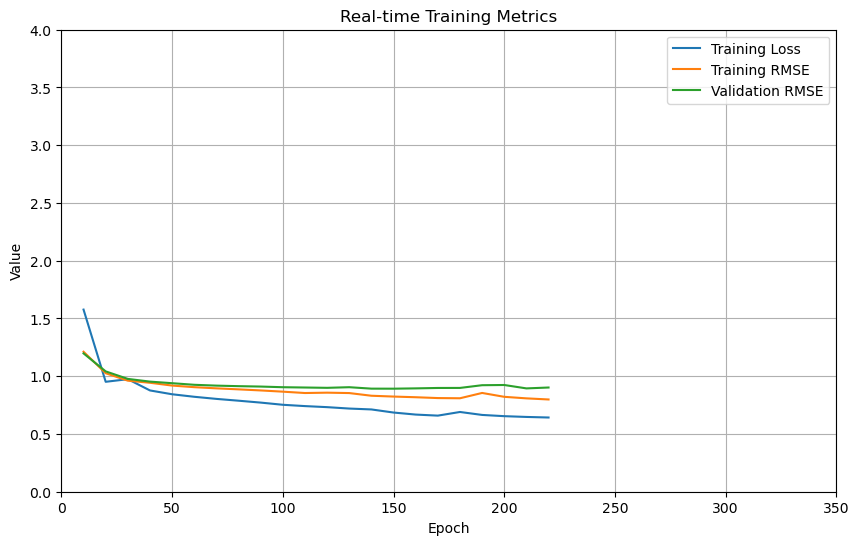

Early stopping triggered at epoch 225. Best validation RMSE: 0.8941 at epoch 193.
Best model with lowest validation RMSE restored from epoch 193.

TensorBoard training information of model GraphSAGE_based_model saved at path: D:\Internship\trained_models\runs\training_plot_GraphSAGE_based_model_350_epochs_0.01_lr

Trained model GraphSAGE_based_model saved at path: D:\Internship\trained_models


In [26]:
GraphSAGE_model.train(num_epochs=350, trained_model_path=trained_models_path, plot_train_loop=True)

In [27]:
GraphSAGE_model.evaluate_performance()

Device: 'cuda
'
Test RMSE: 0.9062, Test MAE: 0.6929

      userId  movieId  pred_rating  gt_rating
0        514     9645     4.013831        2.5
1         26      286     4.526161        5.0
2        599    44114     3.709818        5.0
3        101     7008     4.106010        4.0
4        101    11443     4.212234        3.0
...      ...      ...          ...        ...
4495     246     2244     3.143507        2.0
4496     104    10299     2.995813        3.0
4497     469     5044     3.402698        3.0
4498     129    36979     3.533116        4.0
4499     563    10009     1.483210        1.0

[4500 rows x 4 columns]


In [28]:
GraphSAGE_recommender = CollaborativeFiltering(model_handler=GraphSAGE_model)

### GAT

In [29]:
GAT_model = GNNModelHandler(
    graph_dataset_handler=gdh,
    gnn_encoder=GATEncoder(hidden_channels=64, out_channels=64)
)

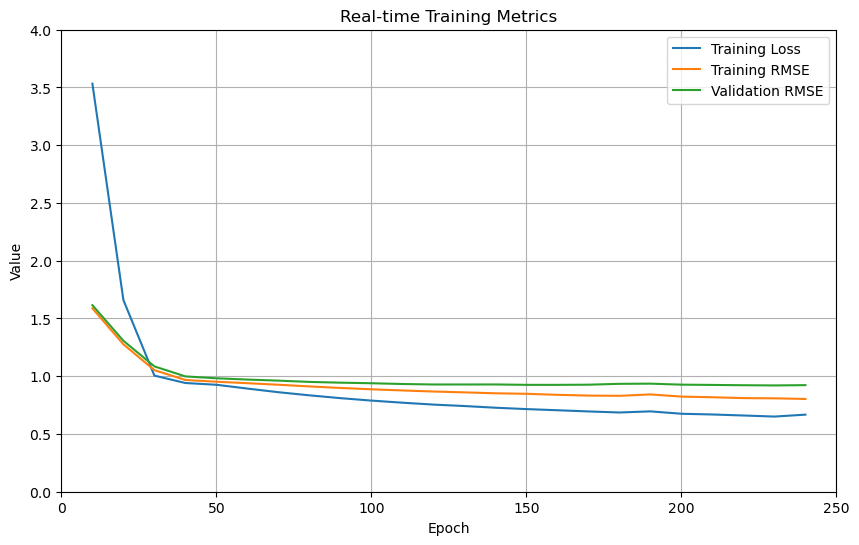

Early stopping triggered at epoch 242. Best validation RMSE: 0.9171 at epoch 213.
Best model with lowest validation RMSE restored from epoch 213.

TensorBoard training information of model GAT_based_model saved at path: D:\Internship\trained_models\runs\training_plot_GAT_based_model_250_epochs_0.01_lr

Trained model GAT_based_model saved at path: D:\Internship\trained_models


In [30]:
GAT_model.train(num_epochs=250, trained_model_path=trained_models_path, plot_train_loop=True)

In [31]:
GAT_model.evaluate_performance()

Device: 'cuda
'
Test RMSE: 0.9252, Test MAE: 0.6969

      userId  movieId  pred_rating  gt_rating
0        521    10370     3.655915        2.5
1         72     8055     3.809354        3.0
2        646     3295     4.123598        3.0
3        620    12280     3.702146        4.0
4        147     7206     4.115911        5.0
...      ...      ...          ...        ...
4495     164     6151     3.404258        2.0
4496     326     4597     3.854416        4.0
4497     344     1299     3.788615        2.0
4498     102     1902     2.591087        1.5
4499     411     8569     2.831781        2.0

[4500 rows x 4 columns]


In [32]:
GAT_recommender = CollaborativeFiltering(model_handler=GAT_model)

In [33]:
# MY COMMENT: RMSE = 1 means that the mean error on rating predictions is around [-1, +1] 
# on a rate that goes from [1, 5] 

## Movie prediction

In [34]:
print("Ground truth ratings of new_user:")
ratings

Ground truth ratings of new_user:


[{'movieId': 19404, 'rating': 1.5, 'userId': 672},
 {'movieId': 27205, 'rating': 2, 'userId': 672},
 {'movieId': 155, 'rating': 3.5, 'userId': 672},
 {'movieId': 157336, 'rating': 3, 'userId': 672},
 {'movieId': 550, 'rating': 3, 'userId': 672},
 {'movieId': 120, 'rating': 5, 'userId': 672},
 {'movieId': 680, 'rating': 2, 'userId': 672},
 {'movieId': 278, 'rating': 1.5, 'userId': 672},
 {'movieId': 122, 'rating': 5, 'userId': 672},
 {'movieId': 13, 'rating': 5, 'userId': 672},
 {'movieId': 121, 'rating': 5, 'userId': 672},
 {'movieId': 11, 'rating': 2.5, 'userId': 672},
 {'movieId': 105, 'rating': 3.5, 'userId': 672},
 {'movieId': 238, 'rating': 3.5, 'userId': 672},
 {'movieId': 1891, 'rating': 2.5, 'userId': 672}]

In [35]:
user_id = new_user_id
movie_id = 1891
pred_rating, gt_rating = GCN_model.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: The Empire Strikes Back, Pred rating: 2.8277, Ground truth rating: 2.5000


In [36]:
user_id = new_user_id
movie_id = 1891
pred_rating, gt_rating = GraphSAGE_model.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: The Empire Strikes Back, Pred rating: 2.6529, Ground truth rating: 2.5000


In [37]:
user_id = new_user_id
movie_id = 1891
pred_rating, gt_rating = GAT_model.predict(user_id, movie_id)

# Extract movie titles as a list
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()

# Check if any titles were found
if movie_titles:
    movie_title = movie_titles[0]   # Display the first title
    print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")
else:
    print(f"No movie found with id {movie_id}")

Movie: The Empire Strikes Back, Pred rating: 2.5692, Ground truth rating: 2.5000


## Movie recommendation

In [38]:
# Suggest a new movie to the user
pred_movie, pred_rating = GraphSAGE_recommender.suggest_new_movie(new_user_id)
movie_title = pred_movie['title'].item()
movie_id = pred_movie['movieId'].item()

print(f"New movie:  {movie_title}, Predicted rating: {pred_rating:.4f}")

New movie:  Without Knowing Anything About Her, Predicted rating: 3.0478


In [39]:
# Prediciton on the previously suggested movie (to check that the predicted rating matches)
movie_titles = gdh.movies_df.loc[gdh.movies_df['id'] == movie_id, 'title'].tolist()
pred_rating, gt_rating = GraphSAGE_recommender.predict(new_user_id, movie_id)

print(f"Movie: {movie_title}, Pred rating: {pred_rating:.4f}, Ground truth rating: {gt_rating:.4f}")

Movie: Without Knowing Anything About Her, Pred rating: 3.0478, Ground truth rating: nan


In [40]:
# Predict ratings for a subset of movies sequentially (slow on large datasets)
subset_movies_df = movies_df.head(10)
pred_ratings = GraphSAGE_recommender.predict_ratings(new_user_id, subset_movies_df)
print(f"Predicted ratings for a subset of {pred_ratings.shape[0]} movies:")
pred_ratings

Predicted ratings for a subset of 10 movies:


,movieId,predicted_rating,ground_truth_rating
0,862,3.010473,NaN
1,8844,2.828910,NaN
2,15602,3.196267,NaN
3,31357,3.103937,NaN
4,11862,3.085480,NaN
5,949,3.904911,NaN
6,11860,2.947244,NaN
7,45325,3.261975,NaN
8,9091,3.017239,NaN
9,710,2.149533,NaN


In [41]:
# Predict ratings for all movies with batched inference optimization (super fast on large datasets)
subset_movies_df = movies_df
pred_ratings = GraphSAGE_recommender.predict_ratings(
    user_id=new_user_id,
    subset_movies_df=subset_movies_df,
    use_batch=True,
)
print(f"Predicted ratings for all {pred_ratings.shape[0]} movies:")
pred_ratings.head(10)

Predicted ratings for all 45433 movies:


,movieId,predicted_rating,ground_truth_rating
0,862,3.010473,NaN
1,8844,2.828910,NaN
2,15602,3.196267,NaN
3,31357,3.103936,NaN
4,11862,3.085480,NaN
5,949,3.904911,NaN
6,11860,2.947244,NaN
7,45325,3.261976,NaN
8,9091,3.017239,NaN
9,710,2.149533,NaN


# Hybrid filtering: GNN-based

## CGN

In [42]:
user_id = 1
movie_title = 'The Dark Knight'

hybrid_GCN_recommender = HybridFiltering(collaborative_filtering=GCN_recommender)
hybrid_GCN_recommender.suggest_similar_movies(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
10158,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.638576,NaN
11399,1124,The Prestige,2006,hughjackman christianbale michaelcaine christo...,3.553869,NaN
15547,27205,Inception,2010,leonardodicaprio josephgordon-levitt ellenpage...,3.205535,NaN
22952,157336,Interstellar,2014,matthewmcconaughey jessicachastain annehathawa...,3.086689,NaN
2474,11660,Following,1998,jeremytheobald alexhaw lucyrussell christopher...,2.958448,NaN
18326,49026,The Dark Knight Rises,2012,christianbale michaelcaine garyoldman christop...,2.907404,NaN
11460,7873,Harsh Times,2005,christianbale freddyrodríguez evalongoria davi...,2.862168,NaN
9177,13428,Two Hands,1999,heathledger bryanbrown rosebyrne gregorjordan ...,2.857138,NaN
7248,10544,Ned Kelly,2003,heathledger orlandobloom geoffreyrush gregorjo...,2.788651,NaN
45711,374720,Dunkirk,2017,fionnwhitehead tomglynn-carney jacklowden chri...,2.756338,NaN


## GraphSAGE

In [43]:
user_id = 1
movie_title = 'The Dark Knight'

hybrid_GraphSAGE_recommender = HybridFiltering(collaborative_filtering=GraphSAGE_recommender)
hybrid_GraphSAGE_recommender.suggest_similar_movies(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
10358,4442,The Brothers Grimm,2005,heathledger mattdamon mackenziecrook terrygill...,3.789355,NaN
10158,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.527051,NaN
11399,1124,The Prestige,2006,hughjackman christianbale michaelcaine christo...,3.069911,NaN
4110,77,Memento,2000,guypearce carrie-annemoss joepantoliano christ...,2.767081,NaN
19247,32050,The Black Windmill,1974,michaelcaine donaldpleasence delphineseyrig do...,2.594522,NaN
11460,7873,Harsh Times,2005,christianbale freddyrodríguez evalongoria davi...,2.589165,NaN
18326,49026,The Dark Knight Rises,2012,christianbale michaelcaine garyoldman christop...,2.488619,NaN
5274,320,Insomnia,2002,alpacino robinwilliams hilaryswank christopher...,2.473668,NaN
18094,123334,TV Junkie,2006,rickkirkham michaelcaine michaelcaine michaelc...,2.288608,NaN
40201,112767,Shadow Run,1998,michaelcaine jamesfox matthewpochin nan nan na...,2.256264,NaN


## GAT

In [44]:
user_id = 1
movie_title = 'The Dark Knight'

hybrid_GAT_recommender = HybridFiltering(collaborative_filtering=GAT_recommender)
hybrid_GAT_recommender.suggest_similar_movies(user_id, movie_title, 25).head(10)

,id,title,year,soup,est_rating,gt_rating
10358,4442,The Brothers Grimm,2005,heathledger mattdamon mackenziecrook terrygill...,4.888023,NaN
4110,77,Memento,2000,guypearce carrie-annemoss joepantoliano christ...,3.710649,NaN
3642,2024,The Patriot,2000,melgibson heathledger joelyrichardson rolandem...,3.611728,NaN
10158,272,Batman Begins,2005,christianbale michaelcaine liamneeson christop...,3.480677,NaN
11399,1124,The Prestige,2006,hughjackman christianbale michaelcaine christo...,3.382837,NaN
40201,112767,Shadow Run,1998,michaelcaine jamesfox matthewpochin nan nan na...,2.843785,NaN
5274,320,Insomnia,2002,alpacino robinwilliams hilaryswank christopher...,2.779907,NaN
3633,479,Shaft,2000,samuell.jackson jeffreywright christianbale jo...,2.771131,NaN
4185,9476,A Knight's Tale,2001,heathledger rufussewell shannynsossamon brianh...,2.573134,NaN
11460,7873,Harsh Times,2005,christianbale freddyrodríguez evalongoria davi...,2.247184,NaN


In [45]:
# Check training plots running:
#   D:\Internship\trained_models> tensorboard --logdir=runs